In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

In [2]:
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

training_data = datasets.MNIST(root="data", train=True, download=True)
test_data = datasets.MNIST(root="data", train=False, download=True)


In [3]:
sample_image, sample_label = training_data[0]
print("Inputs before transformation:", sample_image.size)


Inputs before transformation: (28, 28)


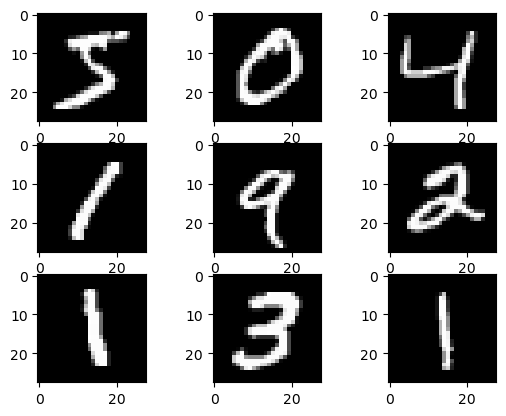

In [4]:
for i, (image, label) in enumerate(training_data):
    if i >= 9:  # Only plot the first 9 images
        break
    plt.subplot(3, 3, i + 1)
    plt.imshow(image, cmap='gray')

In [5]:
#converting to tensor, normalising and flattening
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: torch.flatten(x))
])

In [6]:
training_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [7]:
image_transformed, label_transformed = training_data[0]
print("Transformed image size:", image_transformed.size())

Transformed image size: torch.Size([784])


## Preprocessing Explanation
The data is coverted to tensors to make sure the input is numerical so that operations can be performed on it. The data is normalised to keep weights within a reasonable scale by keeping inputs values within a range such that the mean and standard deviation are 0.5, centering the data around zero. The data is flattened to be of the correct format for the neural network.

In [8]:
train_loader = DataLoader(training_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu 
        
        self.fc1 = nn.Linear(28 * 28, 200)  # input size = 784 (flattened image) 
        self.fc2 = nn.Linear(200, 100) #hidden layer
        self.fc3 = nn.Linear(100, 10) #output layer with 10 classes (0-9)

    def forward(self, x):
        x = self.activation(self.fc1(x))  
        x = self.activation(self.fc2(x))    
        x = self.activation(self.fc3(x))    
        return x

net = Net()

In [10]:
# Optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## Training and Testing

In [ ]:
num_epochs = 10

train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad() #zero out gradients

        #pass through network and loss backpropagation 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

## Tuning Hyperparameters

* adding layers to the neural network
* using leaky relu
* using stochastic gradient descent with momentum instead of adam
* changing number of epochs to 15


In [ ]:
class NewNet(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # After three pooling layers, the size becomes 3x3 (from 28x28).
        self.fc1 = nn.Linear(128*3*3, 500) 
        self.fc2 = nn.Linear(500, 400)
        self.fc3 = nn.Linear(400, 200)
        self.fc4 = nn.Linear(200, 100)
        self.fc5 = nn.Linear(100, 10)
        
        # Activation
        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        
        x = x.view(-1, 128*3*3)  # Flatten after three pooling layers
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.fc5(x)
        
        return x
    
new_net = NewNet()

In [13]:
class MNIST_FC_Net(nn.Module):
    def __init__(self):
        super(MNIST_FC_Net, self).__init__()
    
        self.fc1 = nn.Linear(784, 512)# Input is 28*28 = 784 when flattened
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)  # 10 classes (0-9)
        
        self.activation = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        x = self.activation(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x
    
new_net = MNIST_FC_Net()

In [14]:
optimizer = torch.optim.SGD(new_net.parameters(), lr=0.01, momentum=0.95)

In [15]:
num_epochs = 15

train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    new_net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad() #zero out gradients

        #pass through network and loss backpropagation 
        outputs = new_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))


    val_loss = 0.0
    val_correct = 0
    new_net.eval()
    for inputs, labels in test_loader:
        outputs = new_net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 3.83% training loss: 2.03678
Epoch 1 validation accuracy: 3.24% validation loss: 2.09447
Epoch 2 training accuracy: 2.13% training loss: 2.32121
Epoch 2 validation accuracy: 2.58% validation loss: 2.27326
Epoch 3 training accuracy: 1.95% training loss: 2.30835
Epoch 3 validation accuracy: 3.32% validation loss: 2.19497
Epoch 4 training accuracy: 1.74% training loss: 2.30031
Epoch 4 validation accuracy: 1.53% validation loss: 2.30357
Epoch 5 training accuracy: 1.72% training loss: 2.46152
Epoch 5 validation accuracy: 1.56% validation loss: 2.30604
Epoch 6 training accuracy: 1.69% training loss: 2.31068
Epoch 6 validation accuracy: 1.82% validation loss: 2.30276
Epoch 7 training accuracy: 1.71% training loss: 2.30387
Epoch 7 validation accuracy: 1.82% validation loss: 2.30216


KeyboardInterrupt: 

## Random Restarts

In [ ]:
import copy

num_epochs = 15
num_restarts = 5

# Function to reset model weights
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

best_val_loss = float('inf')
best_model = None

train_loss_history = list()
val_loss_history = list()

for restart in range(num_restarts):

    # Reinitialize model's weights and optimizer
    new_net.apply(weight_reset)
    optimizer = optim.SGD(new_net.parameters(), lr=0.01)  # Assuming fixed learning rate

    print(f"Restart: {restart + 1}")

    for epoch in range(num_epochs):
        new_net.train()
        train_loss = 0.0
        train_correct = 0

        for i, data in enumerate(train_loader):
            inputs, labels = data

            optimizer.zero_grad()  # zero out gradients

            outputs = new_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs.data, 1)
            train_correct += (preds == labels).sum().item()
            train_loss += loss.item()

        print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader.dataset):.2f}% training loss: {train_loss/len(train_loader):.5f}')
        train_loss_history.append(train_loss/len(train_loader))

        val_loss = 0.0
        val_correct = 0
        new_net.eval()
        for inputs, labels in test_loader:
            outputs = new_net(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()

        print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader.dataset):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
        val_loss_history.append(val_loss/len(test_loader))
    
    # Store best model
    if val_loss/len(test_loader) < best_val_loss:
        best_val_loss = val_loss/len(test_loader)
        best_model = copy.deepcopy(new_net)


# Now, after all restarts are done, evaluate the best model on the test set:
best_model.eval()  
test_loss = 0.0
test_correct = 0

for inputs, labels in test_loader:
    outputs = best_model(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)
    test_correct += (preds == labels).sum().item()
    test_loss += loss.item()

print(f'Final test accuracy with best model: {test_correct/len(test_loader.dataset):.2f}% test loss: {test_loss/len(test_loader):.5f}')

# If you wish to save the best model:
torch.save(best_model.state_dict(), 'best_model.pth')

# Later, if you wish to load this model:
# model = SimpleModel()  # or whatever your model class name is
# model.load_state_dict(torch.load('best_model.pth'))
# model.eval()